BTC 4H HYBRID ARIMA ANALYSIS - (EXPANDING WINDOW + DYNAMIC PARAMS)

[1/8] Loading data...
✓ Total observations: 2178
✓ Date range: 2024-06-26 00:00:00 → 2025-06-23 20:00:00

[2/8] Performing stationarity test...
📊 PRICE Series ADF Test (p-value): 0.708212
    Result: ❌ NOT STATIONARY (d=1 required)

[3/8] Splitting data & setting validation parameters...
✓ Initial Training set: 1742 observations
✓ Test set: 436 observations

[+] Hybrid Validation Settings:
    • Method: EXPANDING Window (Stable)
    • Dynamic Parameters: YES (Adaptive)
    • Parameter Refit Frequency: Every 200 steps

[4/8] Defining parameter search function...
    Finding initial parameters on training data...
✓ Initial best parameters: ARIMA(3, 1, 2) (AIC: 28768.24)

[5/8] Starting HYBRID walk-forward validation...
      (Expanding Window + Dynamic Parameters)
    Progress: 100/436 completed (Using ARIMA(3, 1, 2))
    Progress: 200/436 completed (Using ARIMA(3, 1, 2))

----------------------------------------
🔔 Step 

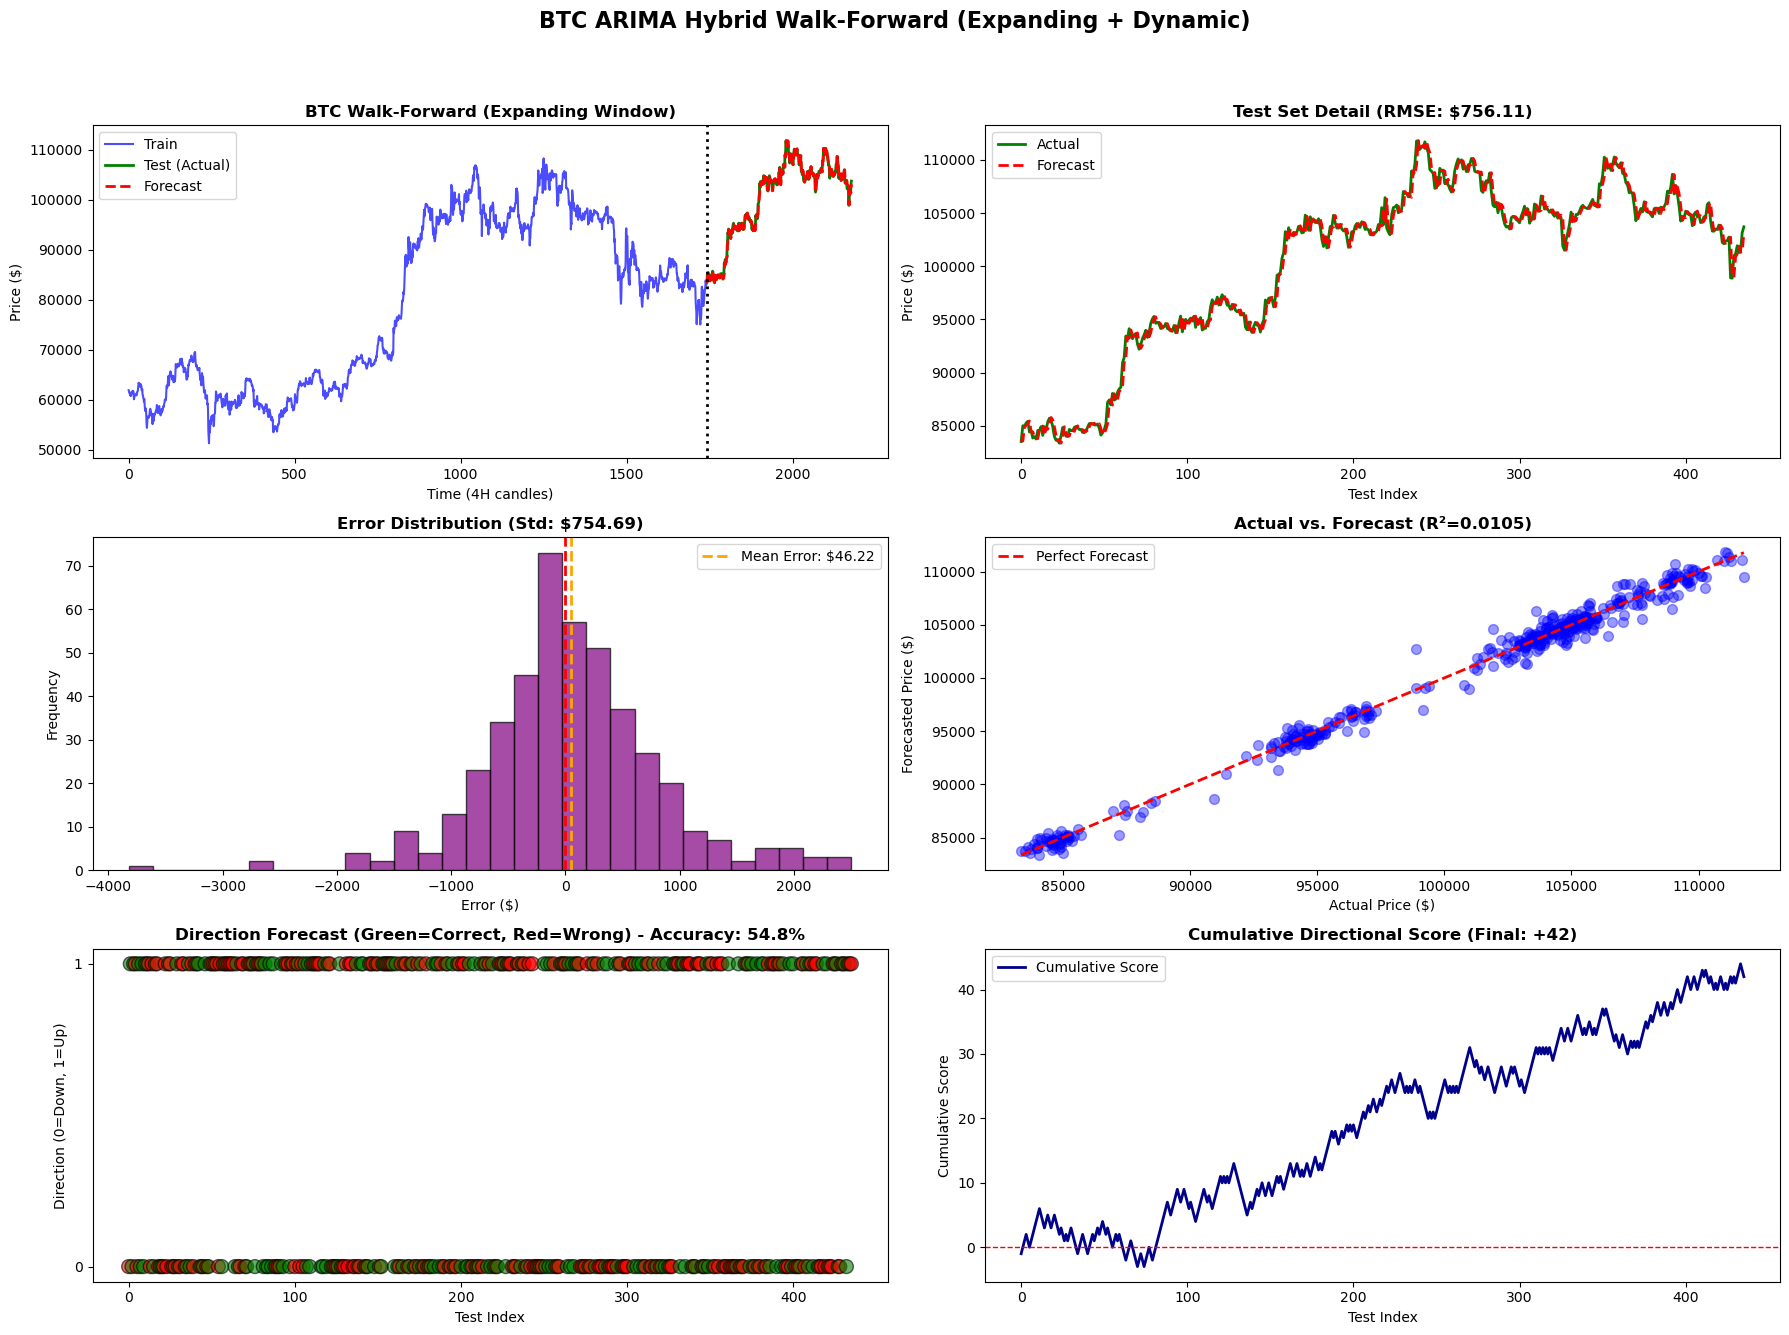


📋 HYBRID SUMMARY REPORT - BTC 4H ARIMA

📁 DATA:
    • File: BTC_LAST1YEAR_4H.csv
    • Total observations: 2178
    • Test duration: 436 candles

🔧 MODEL & VALIDATION:
    • Validation: Walk-Forward
    • Window Type: EXPANDING (Stable)
    • Parameters: DYNAMIC (Adaptive, Refit every 200 steps)

📊 PARAMETER USAGE REPORT:
    • Parameters used during 436 test steps:
    • ARIMA(3, 1, 2): Used 436 times (100.0%)

💰 PRICE FORECASTING:
    • RMSE: $756.11
    • MAPE: 0.54%
    • R² (vs naive): 0.0105

📈 DIRECTIONAL FORECASTING:
    • Accuracy: 54.82%
    • F1-Score: 0.54
    • Final Score: +42

💡 EVALUATION:
    ✅ Directional accuracy is slightly above random guess (50%)
    ✅ R² shows slight predictive power vs naive model.

✅ HYBRID ANALYSIS COMPLETE


In [6]:
#PRICE FORECASTING

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import warnings
import pandas as pd
from collections import Counter # To count parameter usage
import sys # To exit on file error

warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
# Set the coin name and file path here
COIN_NAME = "BTC"
CSV_FILE = f"{COIN_NAME}_LAST1YEAR_4H.csv"
# --- END CONFIGURATION ---

print("=" * 80)
print(f"{COIN_NAME} 4H HYBRID ARIMA ANALYSIS - (EXPANDING WINDOW + DYNAMIC PARAMS)")
print("=" * 80)

# ============================================================================
# STEP 1: DATA LOADING AND PREPROCESSING
# ============================================================================
print("\n[1/8] Loading data...")

try:
    df = pd.read_csv(CSV_FILE)
except FileNotFoundError:
    print(f"FATAL ERROR: The file '{CSV_FILE}' was not found.")
    print("Please make sure the file is in the same directory as the script.")
    sys.exit() # Stop the script
    
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"✓ Total observations: {len(df)}")
print(f"✓ Date range: {df['timestamp'].iloc[0]} → {df['timestamp'].iloc[-1]}")

target_series = df['close'].values
series_name = "Close Price"

# ============================================================================
# STEP 2: STATIONARITY ANALYSIS
# ============================================================================
print("\n[2/8] Performing stationarity test...")
adf_price = adfuller(df['close'].dropna())
print(f"📊 PRICE Series ADF Test (p-value): {adf_price[1]:.6f}")
print(f"    Result: {'❌ NOT STATIONARY (d=1 required)' if adf_price[1] > 0.05 else '✅ STATIONARY'}")

# ============================================================================
# STEP 3: TRAIN-TEST SPLIT & VALIDATION PARAMS
# ============================================================================
print("\n[3/8] Splitting data & setting validation parameters...")

train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train_data_initial = target_series[:train_size] # For first training
test_data = target_series[train_size:]

print(f"✓ Initial Training set: {len(train_data_initial)} observations")
print(f"✓ Test set: {len(test_data)} observations")

# --- HYBRID VALIDATION PARAMETERS ---
# Set parameter refit frequency (e.g., 200)
# This must be smaller than the test_size (436 in your case)
REFIT_PARAMETERS_EVERY_N_STEPS = 200 

print("\n[+] Hybrid Validation Settings:")
print(f"    • Method: EXPANDING Window (Stable)")
print(f"    • Dynamic Parameters: YES (Adaptive)")
print(f"    • Parameter Refit Frequency: Every {REFIT_PARAMETERS_EVERY_N_STEPS} steps")
# --- END ---

# ============================================================================
# STEP 4: PARAMETER SEARCH FUNCTION (Corrected)
# ============================================================================
print("\n[4/8] Defining parameter search function...")

# --- Converted Step 4 into a reusable function (disp=0 error fixed) ---
def find_best_arima_order(data_series):
    """
    Finds the best ARIMA(p,d,q) order based on AIC
    using a grid search on the provided data series.
    """
    best_aic = np.inf
    best_order = None
    
    # We fix d=1 since we are using non-stationary price data
    for p in range(0, 4):
        for d in [1]: 
            for q in range(0, 4):
                if p == 0 and q == 0: # ARIMA(0,1,0)
                    continue
                
                try:
                    model = ARIMA(data_series, order=(p, d, q))
                    fitted = model.fit() # disp=0 removed
                    
                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_order = (p, d, q)
                except:
                    continue
                    
    # Safety check: if no model converges
    if best_order is None:
        best_order = (1, 1, 0)
        try:
            best_aic = ARIMA(data_series, order=best_order).fit().aic # disp=0 removed
        except Exception as e:
            print(f"CRITICAL: Default model (1,1,0) also failed to fit: {e}")
            best_aic = np.inf
        
    return best_order, best_aic

# Find the INITIAL parameters using the *entire* first training set
print("    Finding initial parameters on training data...")
initial_best_order, initial_best_aic = find_best_arima_order(train_data_initial)
print(f"✓ Initial best parameters: ARIMA{initial_best_order} (AIC: {initial_best_aic:.2f})")

# ============================================================================
# STEP 5: WALK-FORWARD VALIDATION (HYBRID)
# ============================================================================
print("\n[5/8] Starting HYBRID walk-forward validation...")
print("      (Expanding Window + Dynamic Parameters)")

predictions_price = []
predictions_direction = []
actual_prices = []
actual_directions = []
parameter_history = [] # To track which parameters are used

current_best_order = initial_best_order

# Loop through each point in the test set
for i in range(len(test_data)):
    
    # --- DYNAMIC PARAMETER CHECK ---
    # Re-find best parameters every N steps
    if (i > 0) and (i % REFIT_PARAMETERS_EVERY_N_STEPS == 0):
        print("\n" + "-"*40)
        print(f"🔔 Step {i}/{len(test_data)}: Re-fitting parameters...")
        
        # --- EXPANDING WINDOW ---
        # Use ALL data up to this point for parameter search
        param_data = target_series[0 : train_size + i]
        
        # Run grid search again
        new_best_order, new_best_aic = find_best_arima_order(param_data)
        
        if new_best_order != current_best_order:
            print(f"    ✅ PARAMETERS CHANGED: New best order is ARIMA{new_best_order} (AIC: {new_best_aic:.2f})")
            current_best_order = new_best_order
        else:
            print(f"    ✓ PARAMETERS CONFIRMED: ARIMA{current_best_order} is still optimal.")
        print("-"*40 + "\n")
    
    # --- EXPANDING WINDOW DATA PREPARATION ---
    # Use ALL data up to this point as 'history'
    history = target_series[0 : train_size + i]
    
    # Train model
    try:
        model = ARIMA(history, order=current_best_order) # Use the current best order
        fitted = model.fit()
        
        # 1-step forward forecast
        forecast = fitted.forecast(steps=1)[0]
        predictions_price.append(forecast)
        
        # Direction forecast (based on last value)
        last_value = history[-1]
        pred_direction = 1 if forecast > last_value else 0
        predictions_direction.append(pred_direction)
        
        # Store actual values
        actual_prices.append(test_data[i])
        actual_direction = 1 if test_data[i] > last_value else 0
        actual_directions.append(actual_direction)
        
        # Store the parameter used for this step
        parameter_history.append(current_best_order)
        
    except Exception as e:
        print(f"    ⚠️ Error at step {i+1}: {str(e)[:50]}")
        # On error, predict the last known value as a fallback
        predictions_price.append(history[-1])
        predictions_direction.append(0)
        actual_prices.append(test_data[i])
        actual_direction = 1 if test_data[i] > history[-1] else 0
        actual_directions.append(actual_direction)
        parameter_history.append(None) # Mark as failed
    
    # Show progress
    if (i + 1) % 100 == 0 or i == len(test_data) - 1:
        print(f"    Progress: {i + 1}/{len(test_data)} completed (Using ARIMA{current_best_order})")

predictions_price = np.array(predictions_price)
predictions_direction = np.array(predictions_direction)
actual_prices = np.array(actual_prices)
actual_directions = np.array(actual_directions)

# ============================================================================
# STEP 6: PRICE FORECASTING PERFORMANCE
# ============================================================================
print("\n[6/8] Calculating price forecast performance...")

rmse = np.sqrt(mean_squared_error(actual_prices, predictions_price))
mae = mean_absolute_error(actual_prices, predictions_price)
mape = np.mean(np.abs((actual_prices - predictions_price) / actual_prices)) * 100

# R² (baseline: predict previous value - naive forecasting)
# Get T-1 values for the entire test set period
naive_predictions = target_series[train_size-1:-1] 
ss_res = np.sum((actual_prices - predictions_price) ** 2)
ss_tot = np.sum((actual_prices - naive_predictions) ** 2)

# Handle ss_tot being zero (if actual price never changed)
if ss_tot == 0:
    r2 = -np.inf if ss_res > 0 else 1.0
else:
    r2 = 1 - (ss_res / ss_tot)

print(f"\n📊 PRICE FORECAST PERFORMANCE:")
print(f"    RMSE: ${rmse:.2f}")
print(f"    MAE:  ${mae:.2f}")
print(f"    MAPE: {mape:.2f}%")
print(f"    R² (vs naive): {r2:.4f}") # R² is crucial

# ============================================================================
# STEP 7: DIRECTIONAL FORECASTING PERFORMANCE
# ============================================================================
print("\n[7/8] Calculating directional forecast performance...")

dir_accuracy = accuracy_score(actual_directions, predictions_direction) * 100

# Confusion matrix
tp = np.sum((actual_directions == 1) & (predictions_direction == 1))
tn = np.sum((actual_directions == 0) & (predictions_direction == 0))
fp = np.sum((actual_directions == 0) & (predictions_direction == 1))
fn = np.sum((actual_directions == 1) & (predictions_direction == 0))

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n📊 DIRECTIONAL FORECAST PERFORMANCE:")
print(f"    Accuracy: {dir_accuracy:.2f}%")
print(f"    F1-Score: {f1:.2f}")
print(f"\n    Confusion Matrix:")
print(f"    TP: {tp} | FP: {fp}")
print(f"    FN: {fn} | TN: {tn}")

# ============================================================================
# STEP 8: VISUALIZATION
# ============================================================================
print("\n[8/8] Generating plots...")

fig, axes = plt.subplots(3, 2, figsize=(18, 14))
fig.suptitle(f'{COIN_NAME} ARIMA Hybrid Walk-Forward (Expanding + Dynamic)', fontsize=16, fontweight='bold')

# 1. Full price series
train_x = np.arange(train_size)
test_x = np.arange(train_size, train_size + len(actual_prices))

axes[0, 0].plot(train_x, df['close'].iloc[:train_size].values,
                label='Train', color='blue', alpha=0.7, linewidth=1.5)
axes[0, 0].plot(test_x, actual_prices,
                label='Test (Actual)', color='green', linewidth=2)
axes[0, 0].plot(test_x, predictions_price,
                label='Forecast', color='red', linestyle='--', linewidth=2)
axes[0, 0].axvline(x=train_size, color='black', linestyle=':', linewidth=2)
axes[0, 0].set_title(f'{COIN_NAME} Walk-Forward (Expanding Window)', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Time (4H candles)')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].legend()

# 2. Test set detail
axes[0, 1].plot(actual_prices, label='Actual', color='green', linewidth=2)
axes[0, 1].plot(predictions_price, label='Forecast', color='red', linewidth=2, linestyle='--')
axes[0, 1].set_title(f'Test Set Detail (RMSE: ${rmse:.2f})', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Test Index')
axes[0, 1].set_ylabel('Price ($)')
axes[0, 1].legend()

# 3. Error distribution
errors = actual_prices - predictions_price
axes[1, 0].hist(errors, bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].axvline(x=np.mean(errors), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean Error: ${np.mean(errors):.2f}')
axes[1, 0].set_title(f'Error Distribution (Std: ${np.std(errors):.2f})', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Error ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# 4. Scatter plot (Added R²)
axes[1, 1].scatter(actual_prices, predictions_price, alpha=0.4, s=50, color='blue')
axes[1, 1].plot([actual_prices.min(), actual_prices.max()],
                [actual_prices.min(), actual_prices.max()],
                'r--', linewidth=2, label='Perfect Forecast')
axes[1, 1].set_title(f'Actual vs. Forecast (R²={r2:.4f})', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Actual Price ($)')
axes[1, 1].set_ylabel('Forecasted Price ($)')
axes[1, 1].legend()

# 5. Directional accuracy time series
colors = ['green' if a == p else 'red' for a, p in zip(actual_directions, predictions_direction)]
axes[2, 0].scatter(range(len(actual_directions)), actual_directions,
                   c=colors, alpha=0.6, s=100, edgecolors='black')
axes[2, 0].set_title(f'Direction Forecast (Green=Correct, Red=Wrong) - Accuracy: {dir_accuracy:.1f}%',
                     fontweight='bold', fontsize=12)
axes[2, 0].set_xlabel('Test Index')
axes[2, 0].set_ylabel('Direction (0=Down, 1=Up)')
axes[2, 0].set_yticks([0, 1])

# 6. Cumulative Score
strategy_returns = []
for i in range(len(actual_directions)):
    actual_move = 1 if actual_directions[i] == 1 else -1
    predicted_move = 1 if predictions_direction[i] == 1 else -1
    strategy_returns.append(actual_move * predicted_move)

cumulative_returns = np.cumsum(strategy_returns)
axes[2, 1].plot(cumulative_returns, linewidth=2, color='darkblue', label='Cumulative Score')
axes[2, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[2, 1].set_title(f'Cumulative Directional Score (Final: {cumulative_returns[-1]:+.0f})',
                     fontweight='bold', fontsize=12)
axes[2, 1].set_xlabel('Test Index')
axes[2, 1].set_ylabel('Cumulative Score')
axes[2, 1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'arima_4h_hybrid_analysis_{COIN_NAME}.png', dpi=300, bbox_inches='tight')
print(f"✓ Plot saved: arima_4h_hybrid_analysis_{COIN_NAME}.png")
plt.show()

# ============================================================================
# SUMMARY REPORT
# ============================================================================
print("\n" + "=" * 80)
print(f"📋 HYBRID SUMMARY REPORT - {COIN_NAME} 4H ARIMA")
print("=" * 80)

print(f"\n📁 DATA:")
print(f"    • File: {CSV_FILE}")
print(f"    • Total observations: {len(df)}")
print(f"    • Test duration: {len(test_data)} candles")

print(f"\n🔧 MODEL & VALIDATION:")
print(f"    • Validation: Walk-Forward")
print(f"    • Window Type: EXPANDING (Stable)")
print(f"    • Parameters: DYNAMIC (Adaptive, Refit every {REFIT_PARAMETERS_EVERY_N_STEPS} steps)")

# --- PARAMETER USAGE REPORT ---
print(f"\n📊 PARAMETER USAGE REPORT:")
param_counts = Counter(parameter_history)
print(f"    • Parameters used during {len(parameter_history)} test steps:")
for order, count in param_counts.items():
    if order is None:
        print(f"    • [FIT FAILED]: {count} times")
    else:
        print(f"    • ARIMA{order}: Used {count} times ({(count/len(parameter_history)*100):.1f}%)")
# --- END ---

print(f"\n💰 PRICE FORECASTING:")
print(f"    • RMSE: ${rmse:.2f}")
print(f"    • MAPE: {mape:.2f}%")
print(f"    • R² (vs naive): {r2:.4f}") # R² is the key metric

print(f"\n📈 DIRECTIONAL FORECASTING:")
print(f"    • Accuracy: {dir_accuracy:.2f}%")
print(f"    • F1-Score: {f1:.2f}")
print(f"    • Final Score: {cumulative_returns[-1]:+.0f}")

print(f"\n💡 EVALUATION:")
if dir_accuracy > 52:
    print("    ✅ Directional accuracy is slightly above random guess (50%)")
elif dir_accuracy > 50:
    print("    ⚠️ Directional accuracy is barely above random guess (50%)")
else:
    print("    ❌ Directional accuracy is at or below random guess")

if r2 > 0.01:
    print("    ✅ R² shows slight predictive power vs naive model.")
elif r2 > 0:
    print("    ⚠️ R² shows weak/no predictive power vs naive model.")
else:
    print("    ❌ R² shows no significant predictive power vs naive model (R² <= 0).")


print("\n" + "=" * 80)
print("✅ HYBRID ANALYSIS COMPLETE")
print("=" * 80)

BTC 4H HYBRID ARIMA ANALYSIS (RETURNS + DYNAMIC PARAMS)

[1/8] Loading data and calculating returns...
✓ Total observations: 2177
✓ Date range: 2024-06-26 04:00:00 → 2025-06-23 20:00:00
✓ Returns range: -7.63% → 6.93%

[2/8] Performing stationarity test...

📊 RETURNS Series ADF Test:
    ADF Statistic: -15.7434
    p-value: 0.000000
    Result: ✅ STATIONARY (d=0 required)

[3/8] Splitting data & setting validation parameters...
✓ Initial Training set: 1741 observations
✓ Test set: 436 observations

[+] Hybrid Validation Settings:
    • Method: EXPANDING Window (Stable, but slow)
    • Dynamic Parameters: YES (Adaptive, but slow)
    • Parameter Refit Frequency: Every 200 steps

[4/8] Defining parameter search function...
    Finding initial parameters on training data...
✓ Initial best parameters: ARIMA(1, 0, 0) (AIC: 5457.24)

[5/8] Starting HYBRID (Returns) walk-forward validation...
      (Expanding Window + Dynamic Parameters)
    Progress: 100/436 completed (Using ARIMA(1, 0, 0))


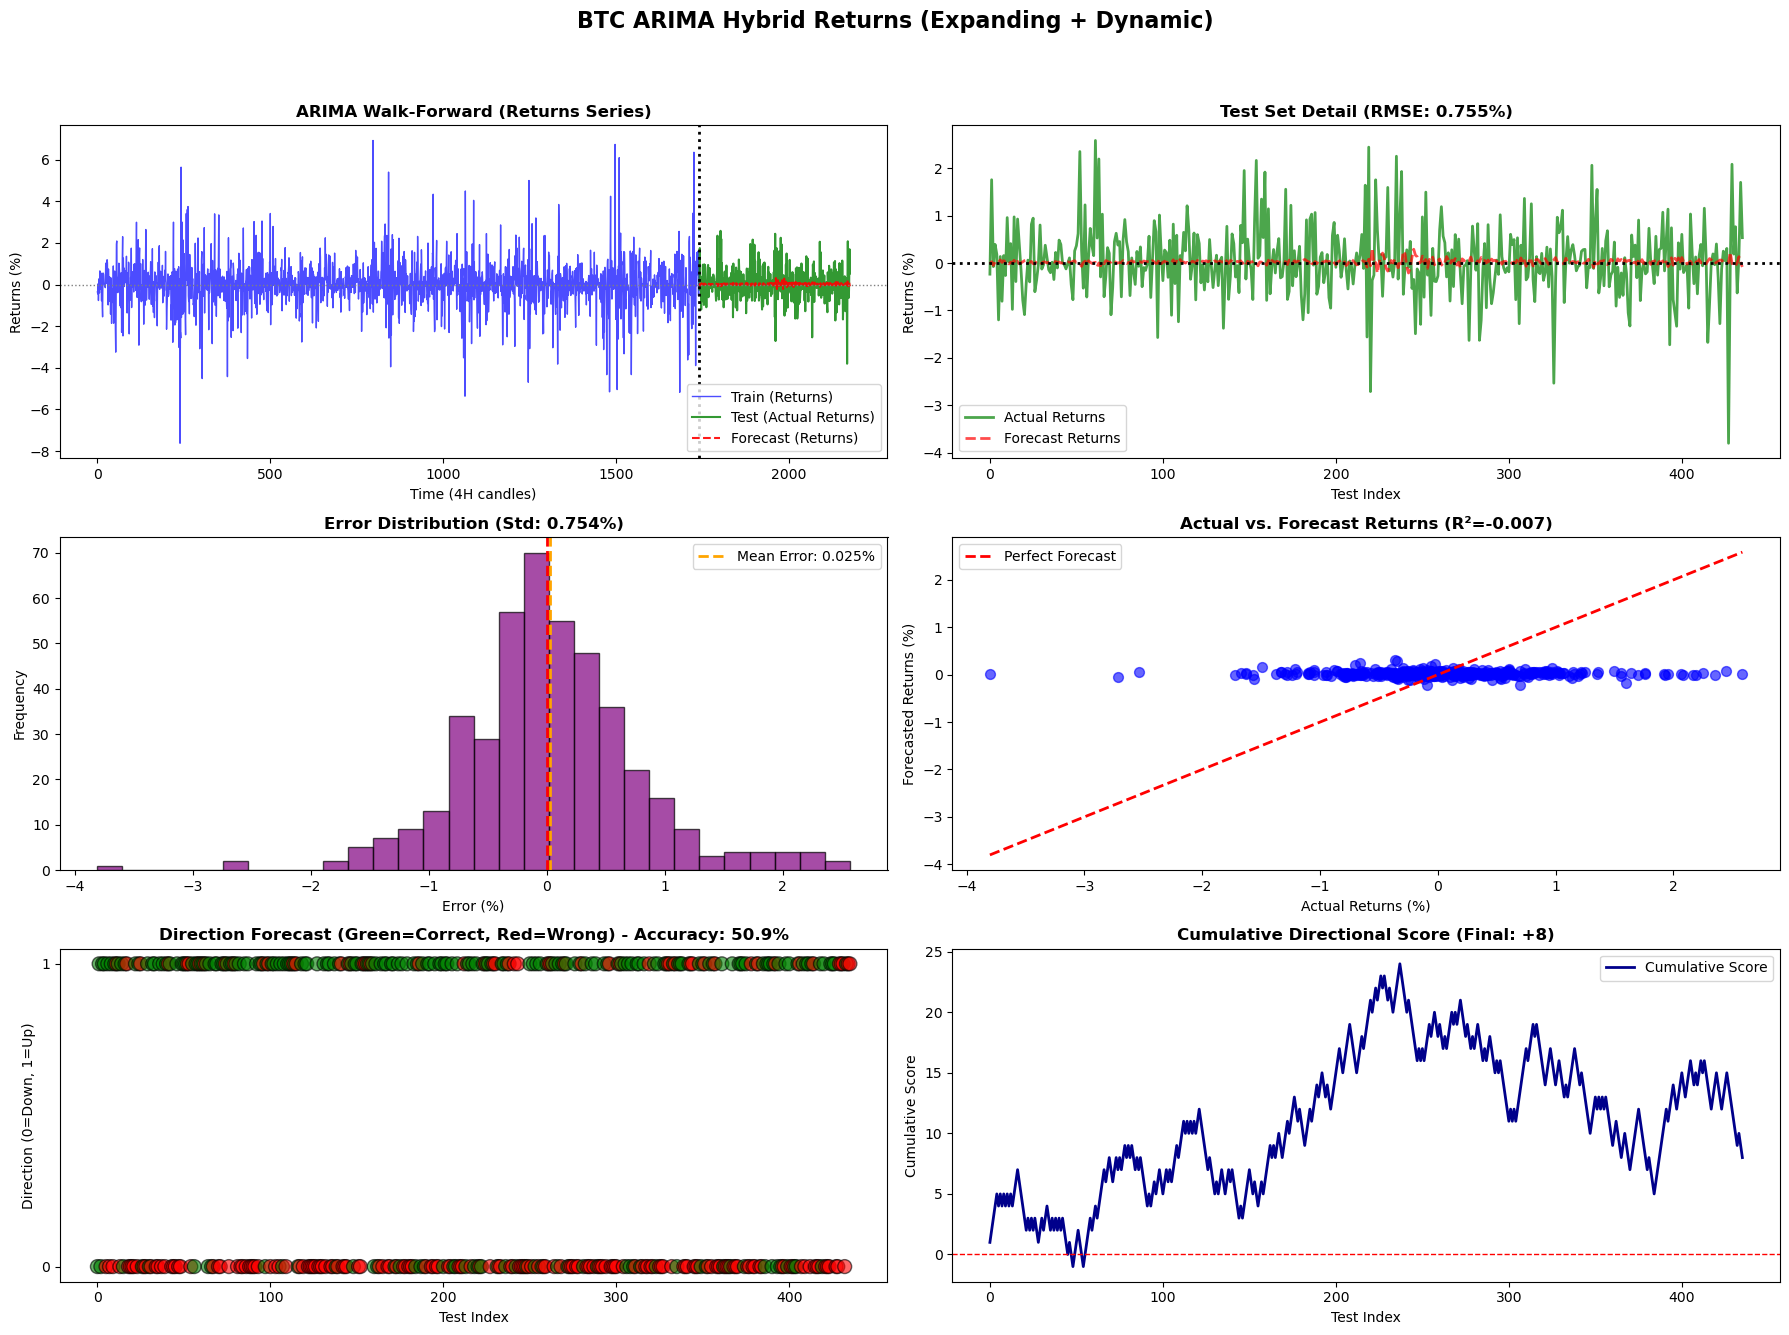


📋 HYBRID SUMMARY REPORT - BTC 4H ARIMA (RETURNS SERIES)

📁 DATA:
    • File: BTC_LAST1YEAR_4H.csv
    • Series Used: Log Returns (%) (Stationary)
    • Test duration: 436 candles

🔧 MODEL & VALIDATION:
    • Validation: Walk-Forward
    • Window Type: EXPANDING (Stable, Slow)
    • Parameters: DYNAMIC (Adaptive, Slow, Refit every 200 steps)

📊 PARAMETER USAGE REPORT:
    • Parameters used during 436 test steps:
    • ARIMA(1, 0, 0): Used 200 times (45.9%)
    • ARIMA(3, 0, 3): Used 236 times (54.1%)

💰 RETURN FORECASTING:
    • RMSE: 0.7547%
    • R² (vs naive '0' guess): -0.0068

📈 DIRECTIONAL FORECASTING:
    • Accuracy: 50.92%
    • F1-Score: 0.61
    • Cumulative score: +8

💡 EVALUATION:
    ⚠️ Directional accuracy is very close to random guess (50%)
    ❌ Return forecast is worse than naive '0' model (R² <= 0)

✅ HYBRID RETURNS ANALYSIS COMPLETE


In [9]:
#RETURNS FORECASTING

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import warnings
import pandas as pd
import sys # To exit on file error
from collections import Counter # To count parameter usage

warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
COIN_NAME = "BTC"
CSV_FILE = f"{COIN_NAME}_LAST1YEAR_4H.csv"
# --- END CONFIGURATION ---

print("=" * 80)
print(f"{COIN_NAME} 4H HYBRID ARIMA ANALYSIS (RETURNS + DYNAMIC PARAMS)")
print("=" * 80)

# ============================================================================
# STEP 1: DATA LOADING AND PREPROCESSING
# ============================================================================
print("\n[1/8] Loading data and calculating returns...")

try:
    df = pd.read_csv(CSV_FILE)
except FileNotFoundError:
    print(f"FATAL ERROR: The file '{CSV_FILE}' was not found.")
    sys.exit()
    
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

df['returns'] = np.log(df['close'] / df['close'].shift(1)) * 100
df = df.dropna()  # Drop the first NaN row

print(f"✓ Total observations: {len(df)}")
print(f"✓ Date range: {df['timestamp'].iloc[0]} → {df['timestamp'].iloc[-1]}")
print(f"✓ Returns range: {df['returns'].min():.2f}% → {df['returns'].max():.2f}%")

target_series = df['returns'].values
series_name = "Log Returns (%)"

# ============================================================================
# STEP 2: STATIONARITY ANALYSIS
# ============================================================================
print("\n[2/8] Performing stationarity test...")

adf_returns = adfuller(df['returns'].dropna())
print(f"\n📊 RETURNS Series ADF Test:")
print(f"    ADF Statistic: {adf_returns[0]:.4f}")
print(f"    p-value: {adf_returns[1]:.6f}")
print(f"    Result: {'❌ NOT STATIONARY' if adf_returns[1] > 0.05 else '✅ STATIONARY (d=0 required)'}")

# ============================================================================
# STEP 3: TRAIN-TEST SPLIT & VALIDATION PARAMS
# ============================================================================
print("\n[3/8] Splitting data & setting validation parameters...")

train_size = int(len(target_series) * 0.8)
test_size = len(target_series) - train_size
train_data_initial = target_series[:train_size] # For first training AND plotting
test_data = target_series[train_size:]

print(f"✓ Initial Training set: {len(train_data_initial)} observations")
print(f"✓ Test set: {len(test_data)} observations")

# --- HYBRID VALIDATION PARAMETERS ---
REFIT_PARAMETERS_EVERY_N_STEPS = 200 

print("\n[+] Hybrid Validation Settings:")
print(f"    • Method: EXPANDING Window (Stable, but slow)")
print(f"    • Dynamic Parameters: YES (Adaptive, but slow)")
print(f"    • Parameter Refit Frequency: Every {REFIT_PARAMETERS_EVERY_N_STEPS} steps")
# --- END ---

# ============================================================================
# STEP 4: PARAMETER SEARCH FUNCTION (FOR d=0)
# ============================================================================
print("\n[4/8] Defining parameter search function...")

def find_best_arima_order(data_series):
    best_aic = np.inf
    best_order = None
    
    for p in range(0, 4):
        for d in [0]: # d=0 for Returns
            for q in range(0, 4):
                if p == 0 and q == 0: continue
                try:
                    model = ARIMA(data_series, order=(p, d, q))
                    fitted = model.fit() 
                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_order = (p, d, q)
                except:
                    continue
                    
    if best_order is None: # Safety check
        best_order = (1, 0, 1) 
        try:
            best_aic = ARIMA(data_series, order=best_order).fit().aic
        except Exception as e:
            print(f"CRITICAL: Default model (1,0,1) also failed to fit: {e}")
            best_aic = np.inf
        
    return best_order, best_aic

# Find the INITIAL parameters using the *entire* first training set
print("    Finding initial parameters on training data...")
initial_best_order, initial_best_aic = find_best_arima_order(train_data_initial)
print(f"✓ Initial best parameters: ARIMA{initial_best_order} (AIC: {initial_best_aic:.2f})")

# ============================================================================
# STEP 5: WALK-FORWARD VALIDATION (HYBRID - RETURNS)
# ============================================================================
print("\n[5/8] Starting HYBRID (Returns) walk-forward validation...")
print("      (Expanding Window + Dynamic Parameters)")

predictions_return = []
predictions_direction = []
actual_returns = []
actual_directions = []
parameter_history = [] 

current_best_order = initial_best_order

for i in range(len(test_data)):
    
    # --- DYNAMIC PARAMETER CHECK ---
    if (i > 0) and (i % REFIT_PARAMETERS_EVERY_N_STEPS == 0):
        print("\n" + "-"*40)
        print(f"🔔 Step {i}/{len(test_data)}: Re-fitting parameters...")
        
        # --- EXPANDING WINDOW ---
        param_data = target_series[0 : train_size + i]
        
        new_best_order, new_best_aic = find_best_arima_order(param_data)
        
        if new_best_order != current_best_order:
            print(f"    ✅ PARAMETERS CHANGED: New best order is ARIMA{new_best_order} (AIC: {new_best_aic:.2f})")
            current_best_order = new_best_order
        else:
            print(f"    ✓ PARAMETERS CONFIRMED: ARIMA{current_best_order} is still optimal.")
        print("-"*40 + "\n")
    
    # --- EXPANDING WINDOW DATA PREPARATION ---
    history = target_series[0 : train_size + i]
    
    # Train model (at every step)
    try:
        model = ARIMA(history, order=current_best_order) 
        fitted = model.fit()
        
        forecast = fitted.forecast(steps=1)[0]
        predictions_return.append(forecast)
        
        pred_direction = 1 if forecast > 0 else 0
        predictions_direction.append(pred_direction)
        
        actual_returns.append(test_data[i])
        actual_direction = 1 if test_data[i] > 0 else 0
        actual_directions.append(actual_direction)
        
        parameter_history.append(current_best_order)
        
    except Exception as e:
        print(f"    ⚠️ Error at step {i+1}: {str(e)[:50]}")
        predictions_return.append(0.0) 
        predictions_direction.append(0)
        actual_returns.append(test_data[i])
        actual_direction = 1 if test_data[i] > 0 else 0
        actual_directions.append(actual_direction)
        parameter_history.append(None) 
    
    if (i + 1) % 100 == 0 or i == len(test_data) - 1:
        print(f"    Progress: {i+1}/{len(test_data)} completed (Using ARIMA{current_best_order})")

predictions_return = np.array(predictions_return)
predictions_direction = np.array(predictions_direction)
actual_returns = np.array(actual_returns)
actual_directions = np.array(actual_directions)

# ============================================================================
# STEP 6: RETURN FORECASTING PERFORMANCE
# ============================================================================
print("\n[6/8] Calculating return forecast performance...")

rmse = np.sqrt(mean_squared_error(actual_returns, predictions_return))
mae = mean_absolute_error(actual_returns, predictions_return)

naive_predictions = np.zeros_like(actual_returns)
ss_res = np.sum((actual_returns - predictions_return) ** 2)
ss_tot = np.sum((actual_returns - naive_predictions) ** 2)
r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 1.0


print(f"\n📊 RETURN FORECAST PERFORMANCE:")
print(f"    RMSE: {rmse:.4f}%")
print(f"    MAE:  {mae:.4f}%")
print(f"    R² (vs naive '0' guess): {r2:.4f}")

# ============================================================================
# STEP 7: DIRECTIONAL FORECASTING PERFORMANCE
# ============================================================================
print("\n[7/8] Calculating directional forecast performance...")

dir_accuracy = accuracy_score(actual_directions, predictions_direction) * 100

tp = np.sum((actual_directions == 1) & (predictions_direction == 1))
tn = np.sum((actual_directions == 0) & (predictions_direction == 0))
fp = np.sum((actual_directions == 0) & (predictions_direction == 1))
fn = np.sum((actual_directions == 1) & (predictions_direction == 0))

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n📊 DIRECTIONAL FORECAST PERFORMANCE:")
print(f"    Accuracy: {dir_accuracy:.2f}%")
print(f"    F1-Score: {f1:.2f}")
print(f"\n    Confusion Matrix:")
print(f"    TP: {tp} | FP: {fp}")
print(f"    FN: {fn} | TN: {tn}")

# ============================================================================
# STEP 8: VISUALIZATION (BUG FIXED)
# ============================================================================
print("\n[8/8] Generating plots...")

fig, axes = plt.subplots(3, 2, figsize=(18, 14))
fig.suptitle(f'{COIN_NAME} ARIMA Hybrid Returns (Expanding + Dynamic)', fontsize=16, fontweight='bold')

# 1. Full returns series
train_x = np.arange(train_size)
test_x = np.arange(train_size, train_size + len(actual_returns))

# --- HATA DÜZELTMESİ (BUG FIX) ---
# 'train_data' (potansiyel olarak eski hafızadan 1742) yerine 
# bu script'te ADIM 3'te tanımlanan 'train_data_initial' (1741) kullanılır.
axes[0, 0].plot(train_x, train_data_initial,
                label='Train (Returns)', color='blue', alpha=0.7, linewidth=1)
# --- Düzeltme Bitti ---

axes[0, 0].plot(test_x, actual_returns,
                label='Test (Actual Returns)', color='green', linewidth=1.5, alpha=0.8)
axes[0, 0].plot(test_x, predictions_return,
                label='Forecast (Returns)', color='red', linestyle='--', linewidth=1.5, alpha=0.9)
axes[0, 0].axvline(x=train_size, color='black', linestyle=':', linewidth=2)
axes[0, 0].axhline(y=0, color='gray', linestyle=':', linewidth=1)
axes[0, 0].set_title(f'ARIMA Walk-Forward (Returns Series)', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Time (4H candles)')
axes[0, 0].set_ylabel('Returns (%)')
axes[0, 0].legend()

# (Diğer tüm grafik çizim kodları aynı kalır)
# 2. Test set detail
axes[0, 1].plot(actual_returns, label='Actual Returns', color='green', linewidth=2, alpha=0.7)
axes[0, 1].plot(predictions_return, label='Forecast Returns', color='red', linewidth=2, linestyle='--', alpha=0.7)
axes[0, 1].axhline(y=0, color='black', linestyle=':', linewidth=2)
axes[0, 1].set_title(f'Test Set Detail (RMSE: {rmse:.3f}%)', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Test Index')
axes[0, 1].set_ylabel('Returns (%)')
axes[0, 1].legend()

# 3. Error distribution
errors = actual_returns - predictions_return
axes[1, 0].hist(errors, bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].axvline(x=np.mean(errors), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean Error: {np.mean(errors):.3f}%')
axes[1, 0].set_title(f'Error Distribution (Std: {np.std(errors):.3f}%)', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Error (%)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# 4. Scatter plot
axes[1, 1].scatter(actual_returns, predictions_return, alpha=0.6, s=50, color='blue')
axes[1, 1].plot([actual_returns.min(), actual_returns.max()],
                [actual_returns.min(), actual_returns.max()],
                'r--', linewidth=2, label='Perfect Forecast')
axes[1, 1].set_title(f'Actual vs. Forecast Returns (R²={r2:.3f})', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Actual Returns (%)')
axes[1, 1].set_ylabel('Forecasted Returns (%)')
axes[1, 1].legend()

# 5. Directional accuracy time series
colors = ['green' if a == p else 'red' for a, p in zip(actual_directions, predictions_direction)]
axes[2, 0].scatter(range(len(actual_directions)), actual_directions,
                   c=colors, alpha=0.6, s=100, edgecolors='black')
axes[2, 0].set_title(f'Direction Forecast (Green=Correct, Red=Wrong) - Accuracy: {dir_accuracy:.1f}%',
                     fontweight='bold', fontsize=12)
axes[2, 0].set_xlabel('Test Index')
axes[2, 0].set_ylabel('Direction (0=Down, 1=Up)')
axes[2, 0].set_yticks([0, 1])

# 6. Cumulative score
strategy_returns_score = []
for i in range(len(actual_directions)):
    actual_move = 1 if actual_directions[i] == 1 else -1
    predicted_move = 1 if predictions_direction[i] == 1 else -1
    strategy_returns_score.append(1 if actual_move == predicted_move else -1)

cumulative_returns = np.cumsum(strategy_returns_score)
axes[2, 1].plot(cumulative_returns, linewidth=2, color='darkblue', label='Cumulative Score')
axes[2, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[2, 1].set_title(f'Cumulative Directional Score (Final: {cumulative_returns[-1]:+.0f})',
                     fontweight='bold', fontsize=12)
axes[2, 1].set_xlabel('Test Index')
axes[2, 1].set_ylabel('Cumulative Score')
axes[2, 1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'arima_hybrid_returns_analysis_{COIN_NAME}.png', dpi=300, bbox_inches='tight')
print(f"✓ Plot saved: arima_hybrid_returns_analysis_{COIN_NAME}.png")
plt.show()

# ============================================================================
# SUMMARY REPORT
# ============================================================================
print("\n" + "=" * 80)
print(f"📋 HYBRID SUMMARY REPORT - {COIN_NAME} 4H ARIMA (RETURNS SERIES)")
print("=" * 80)

print(f"\n📁 DATA:")
print(f"    • File: {CSV_FILE}")
print(f"    • Series Used: {series_name} (Stationary)")
print(f"    • Test duration: {len(test_data)} candles")

print(f"\n🔧 MODEL & VALIDATION:")
print(f"    • Validation: Walk-Forward")
print(f"    • Window Type: EXPANDING (Stable, Slow)")
print(f"    • Parameters: DYNAMIC (Adaptive, Slow, Refit every {REFIT_PARAMETERS_EVERY_N_STEPS} steps)")

print(f"\n📊 PARAMETER USAGE REPORT:")
param_counts = Counter(parameter_history)
print(f"    • Parameters used during {len(parameter_history)} test steps:")
for order, count in param_counts.items():
    if order is None:
        print(f"    • [FIT FAILED]: {count} times")
    else:
        print(f"    • ARIMA{order}: Used {count} times ({(count/len(parameter_history)*100):.1f}%)")

print(f"\n💰 RETURN FORECASTING:")
print(f"    • RMSE: {rmse:.4f}%")
print(f"    • R² (vs naive '0' guess): {r2:.4f}")

print(f"\n📈 DIRECTIONAL FORECASTING:")
print(f"    • Accuracy: {dir_accuracy:.2f}%")
print(f"    • F1-Score: {f1:.2f}")
print(f"    • Cumulative score: {cumulative_returns[-1]:+.0f}")

print(f"\n💡 EVALUATION:")
if dir_accuracy > 52:
    print("    ✅ Directional accuracy is slightly above random guess (50%)")
elif dir_accuracy >= 50:
    print("    ⚠️ Directional accuracy is very close to random guess (50%)")
else:
    print("    ❌ Directional accuracy is worse than random")

if r2 > 0:
    print("    ⚠️ Return forecast is only slightly better than naive '0' model (R² > 0)")
else:
    print("    ❌ Return forecast is worse than naive '0' model (R² <= 0)")

print("\n" + "=" * 80)
print("✅ HYBRID RETURNS ANALYSIS COMPLETE")
print("=" * 80)